In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input #feature extraction
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [2]:
BASE_DIR = "/kaggle/input/flickr30k"
WORKING_DIR = "/kaggle/working"

# Extracting Features from the images

In [3]:
# load vgg16 model
model = VGG16()
#restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

2022-06-30 18:04:02.145356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 18:04:02.280529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 18:04:02.281704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 18:04:02.283423: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

553476096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [4]:
# extra features from image
# value ==> fetures
features = {}

directory = os.path.join(BASE_DIR, "images")

for img_name in tqdm(os.listdir(directory)):
    try:
        # loading the images from file
        img_path =  directory + "/" + img_name
        image = load_img(img_path, target_size=(224,224))

        # converting the pixels of the image into a numpy array
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # reshaping the data for our model
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)

        #Extracting the image ID
        image_id = img_name.split(".")[0]

        #store feature
        features[image_id] = feature
    except Exception as e:
        print("Exception occured", e.__class__)
        continue

  0%|          | 0/31785 [00:00<?, ?it/s]

2022-06-30 18:04:14.006903: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-30 18:04:15.178957: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Exception occured <class 'IsADirectoryError'>
Exception occured <class 'PIL.UnidentifiedImageError'>


In [5]:
#storing features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'),'wb')) 
# write binary

In [6]:
# Load features from pickle
FEATURES_PATH = "/kaggle/input/featurespkl/features.pkl"
with open(FEATURES_PATH,'rb') as f:
    features = pickle.load(f)

## Loading the captions Data

In [7]:
CAPTIONS_PATH = "/kaggle/input/captions/captions.txt"
with open(CAPTIONS_PATH,"r") as f:
    next(f)
    captions_doc = f.read()

In [8]:
#mapping the images to its corresponding captions
mapping = {}

# process lines
for line in tqdm(captions_doc.split("\n")):
    # spliting the lines by ","
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    
    #removing extensions from yhe given image IDs
    image_id = image_id.split(".")[0]
    image_id = image_id.replace(" ","")
    
    # Converting the caption list into string
    caption = " ".join(caption)
    
    #Create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    
    #Store the caption
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [9]:
len(mapping)

31783

# Preprocess Data

In [10]:
# before preprocess of text
mapping['1000092795']

[' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 ' Two young   White males are outside near many bushes .',
 ' Two men in green shirts are standing in a yard .',
 ' A man in a blue shirt standing in a garden .',
 ' Two friends enjoy time spent together .']

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # One at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lower case
            caption = caption.lower()
            # Replace digits, special haracters etc
            caption = caption.replace("[^A-Za-z]","")
            # Delete additional spaces
            caption = caption.replace('\s+',' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
# preprocessing the text
clean(mapping)

In [13]:
# after preprocessing of text
mapping['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

158915

In [16]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [17]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

18313

In [19]:
# get maximum length of the captions available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

# Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)

# Training image ids 0-90% 
train = image_ids[:split] 

# Testing image ids 90-100% 
test = image_ids[split:]

In [21]:
# Create Data Generator to get data  in batch (prevents session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size,  batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into x, y pairs
                for i in range(1,len(seq)):
                    #split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    #pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    #store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y =list(), list(), list()
                n = 0
                

# Model Creation

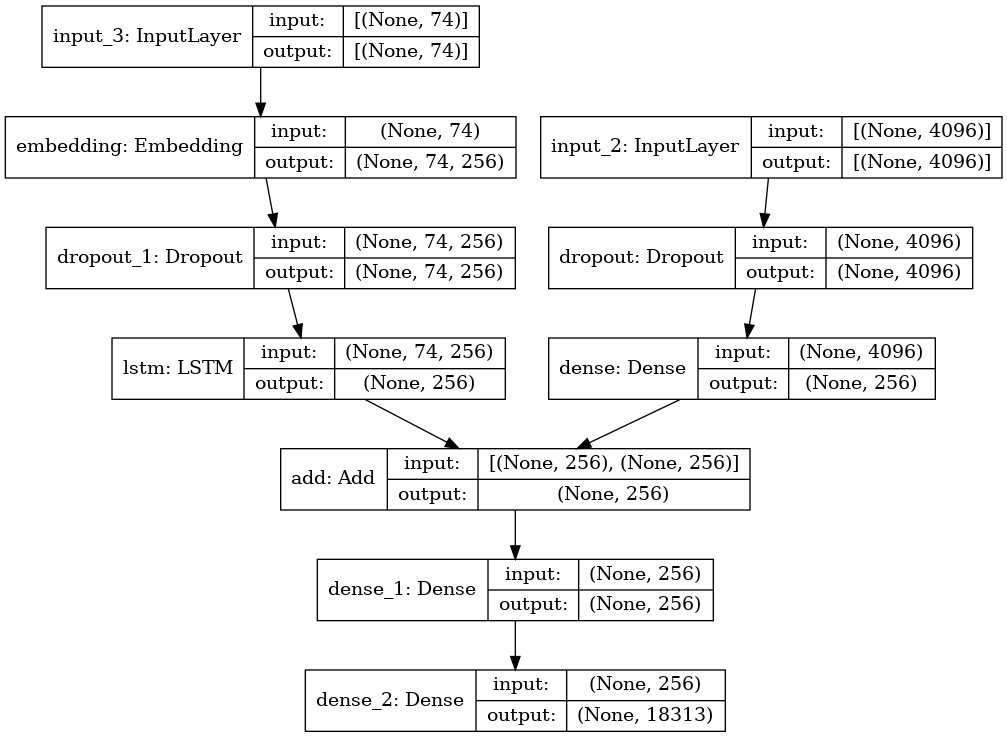

In [22]:
#encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer = 'adam')

#plot the model
plot_model(model,show_shapes=True)

In [23]:
# train the model
epochs = 20
batch_size = 35
steps = len(train) // batch_size

for i in range(epochs):
    #create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


817/817 [==============================] - 638s 780ms/step - loss: 2.7067


In [24]:
# save the model
model.save('/kaggle/working/best_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Generate captions for the image

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text+=" "+word
        #stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [27]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    #get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    #split into words
    actual_captions = [caption.split() for caption in captions] 
    y_pred = y_pred.split()
    
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calculate the BLEU score
print("BLEU-1: %f" %corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" %corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/3179 [00:00<?, ?it/s]

BLEU-1: 0.549646
BLEU-2: 0.300858


# Visualize the Results

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(image_path)
    captions = mapping[image_id]
    print("**********************ACTUAL***********************")
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("**********************PREDICTED***********************")
    print(y_pred)
    plt.imshow(image)

**********************ACTUAL***********************
startseq several men in hard hats are operating giant pulley system endseq
startseq workers look down from up above on piece of equipment endseq
startseq two men working on machine wearing hard hats endseq
startseq four men on top of tall structure endseq
startseq three men on large rig endseq
**********************PREDICTED***********************
startseq man is suspended on pole while suspended in the air endseq


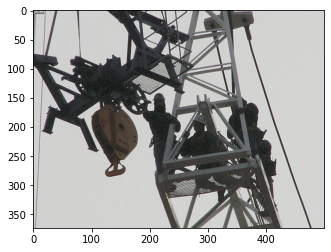

In [29]:
generate_caption("10002456.jpg")

**********************ACTUAL***********************
startseq three people are on hilltop overlooking green valley endseq
startseq people sit on the mountainside and check out the view endseq
startseq three people rest on ledge above the moutains endseq
startseq three people hang out on top of big hill endseq
startseq three people overlook green valley endseq
**********************PREDICTED***********************
startseq two people are hiking up hill on hilltop endseq


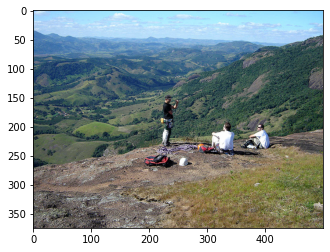

In [30]:
generate_caption("104136873.jpg")

**********************ACTUAL***********************
startseq man on ladder is painting brick wall in warehouse endseq
startseq man is standing on ladder painting bricks endseq
startseq construction site with building material endseq
startseq man painting brick wall on ladder endseq
startseq man is panting piece of wood endseq
**********************PREDICTED***********************
startseq man in black shirt and black pants is standing on ladder in front of an escalator endseq


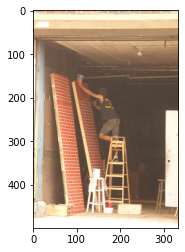

In [31]:
generate_caption("1044764620.jpg")

**********************ACTUAL***********************
startseq two people sitting beside each other at table with food on it smiling endseq
startseq couple wearing white sweaters sit at restaurant table endseq
startseq man and woman seated at table together endseq
startseq man and woman eating dinner together endseq
startseq man and woman wearing khaki smiling endseq
**********************PREDICTED***********************
startseq two women are eating at restaurant endseq


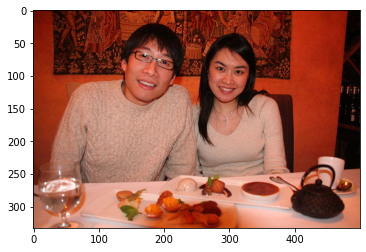

In [32]:
generate_caption("105493603.jpg")

**********************ACTUAL***********************
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq little girl in pink dress going into wooden cabin endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl climbing into wooden playhouse endseq
startseq girl going into wooden building endseq
**********************PREDICTED***********************
startseq man in white shirt is sitting on stool on the sidewalk endseq


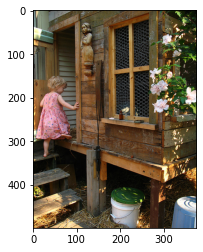

In [33]:
generate_caption("1000268201.jpg")